# Exploratory Data Analysis

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud 
from nltk.tokenize import word_tokenize 


nltk.download('stopwords', quiet=True)
stopwords = stopwords.words('english')
sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [10,8]
pd.set_option.display_max_columns = 0
pd.set_option.display_max_rows = 0

In [2]:
train = pd.read_csv("../input/covid19-tweet-classification-by-zindiweekendz/updated_train.csv")
test = pd.read_csv("../input/covid19-tweet-classification-by-zindiweekendz/updated_test.csv")

In [3]:
train.head()

,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0


In [4]:
train.shape, test.shape, test.shape[0]/train.shape[0]

((5287, 3), (1962, 2), 0.37109892188386606)

In [5]:
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 5287 rows and 3 columns in train
There are 1962 rows and 2 columns in train


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5287 entries, 0 to 5286
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      5287 non-null   object
 1   text    5287 non-null   object
 2   target  5287 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 124.0+ KB


In [7]:
null_counts = pd.DataFrame({"Num_Null": train.isnull().sum()})
null_counts["Pct_Null"] = null_counts["Num_Null"] / train.count() * 100
null_counts

,Num_Null,Pct_Null
ID,0,0.0
text,0,0.0
target,0,0.0


### Keyword

What are some of the most commonly used keywords?

In [8]:
disaster_locations = train.loc[train["target"] == 1]["location"].value_counts()
nondisaster_locations = train.loc[train["target"] == 0]["location"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_locations[0:30].index, x=disaster_locations[0:30], orient='h', ax=ax[0], palette="Reds_d")
sns.barplot(y=nondisaster_locations[0:30].index, x=nondisaster_locations[0:30], orient='h', ax=ax[1], palette="Blues_d")
ax[0].set_title("Top 30 Locations - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 30 Locations - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()

KeyError: 'location'

### Text aka Tweet Content

**tweet length distribution**

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


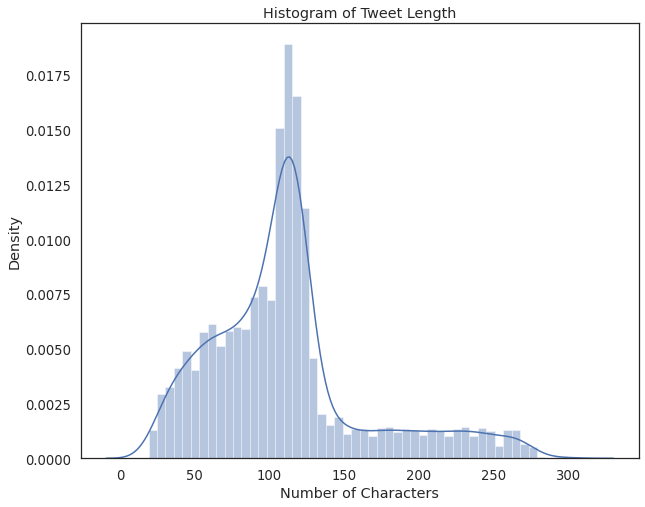

In [9]:
train["tweet_length"] = train["text"].apply(len)
sns.distplot(train["tweet_length"])
plt.title("Histogram of Tweet Length")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

In [10]:
min(train["tweet_length"]), max(train["tweet_length"])

(19, 302)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


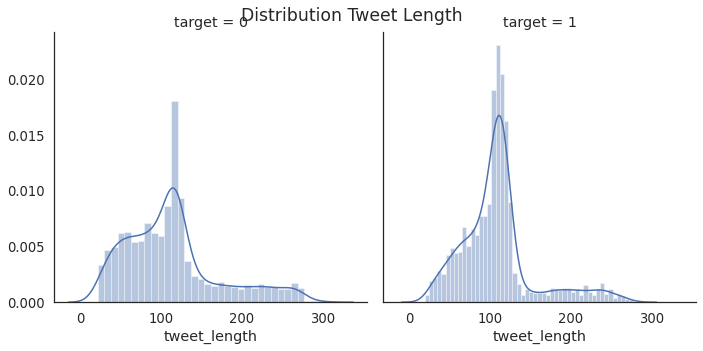

In [11]:
g = sns.FacetGrid(train, col="target", height=5)
g = g.map(sns.distplot, "tweet_length")
plt.suptitle("Distribution Tweet Length")
plt.show()

## Number of Words

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


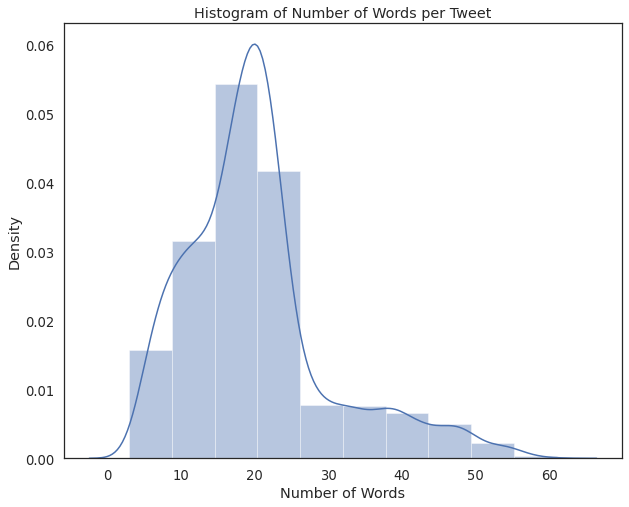

In [12]:
def count_words(x):
    return len(x.split())

train["num_words"] = train["text"].apply(count_words)
sns.distplot(train["num_words"], bins=10)
plt.title("Histogram of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


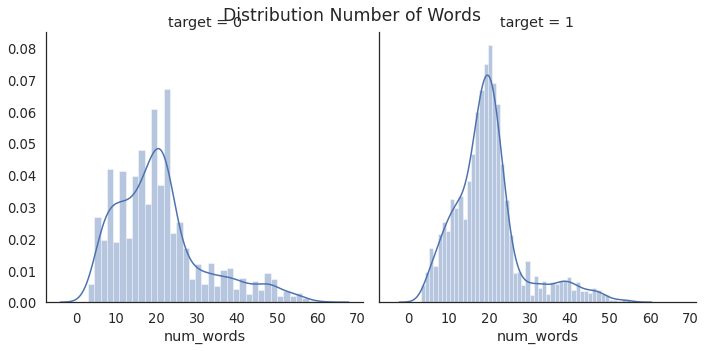

In [13]:
g = sns.FacetGrid(train, col="target", height=5)
g = g.map(sns.distplot, "num_words")
plt.suptitle("Distribution Number of Words")
plt.show()

## Average Word Length

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


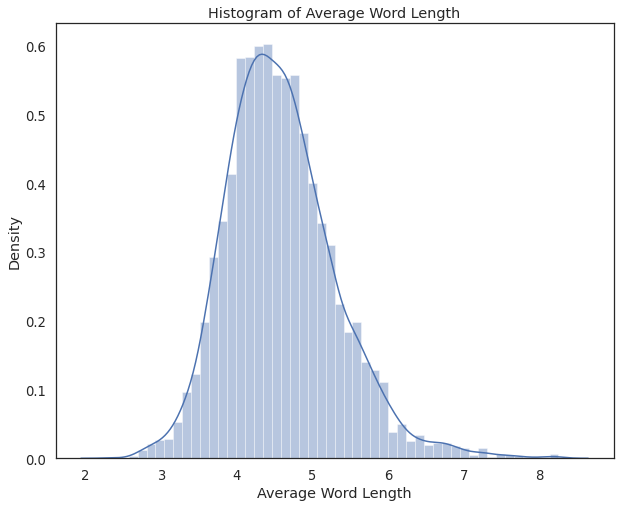

In [14]:
def avg_word_length(x):
    return np.sum([len(w) for w in x.split()]) / len(x.split())

train["avg_word_length"] = train["text"].apply(avg_word_length)
sns.distplot(train["avg_word_length"])
plt.title("Histogram of Average Word Length")
plt.xlabel("Average Word Length")
plt.ylabel("Density")
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


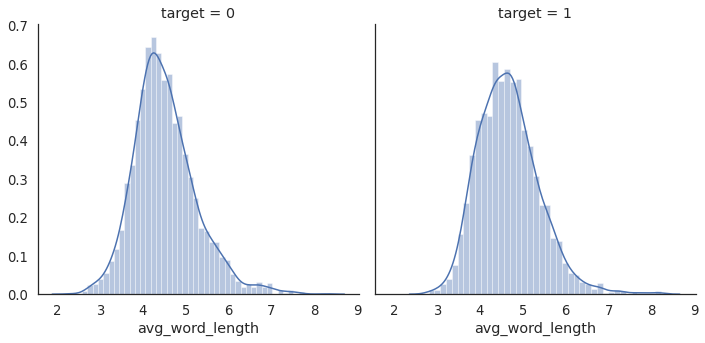

In [15]:
g = sns.FacetGrid(train, col="target", height=5)
g = g.map(sns.distplot, "avg_word_length")

## Common Stopwords

In [16]:
def create_corpus(target):
    corpus = []

    for w in train.loc[train["target"] == target]["text"].str.split():
        for i in w:
            corpus.append(i)
            
    return corpus

def create_corpus_dict(target):
    corpus = create_corpus(target)
            
    stop_dict = defaultdict(int)
    for word in corpus:
        if word in stopwords:
            stop_dict[word] += 1
    return sorted(stop_dict.items(), key=lambda x:x[1], reverse=True)

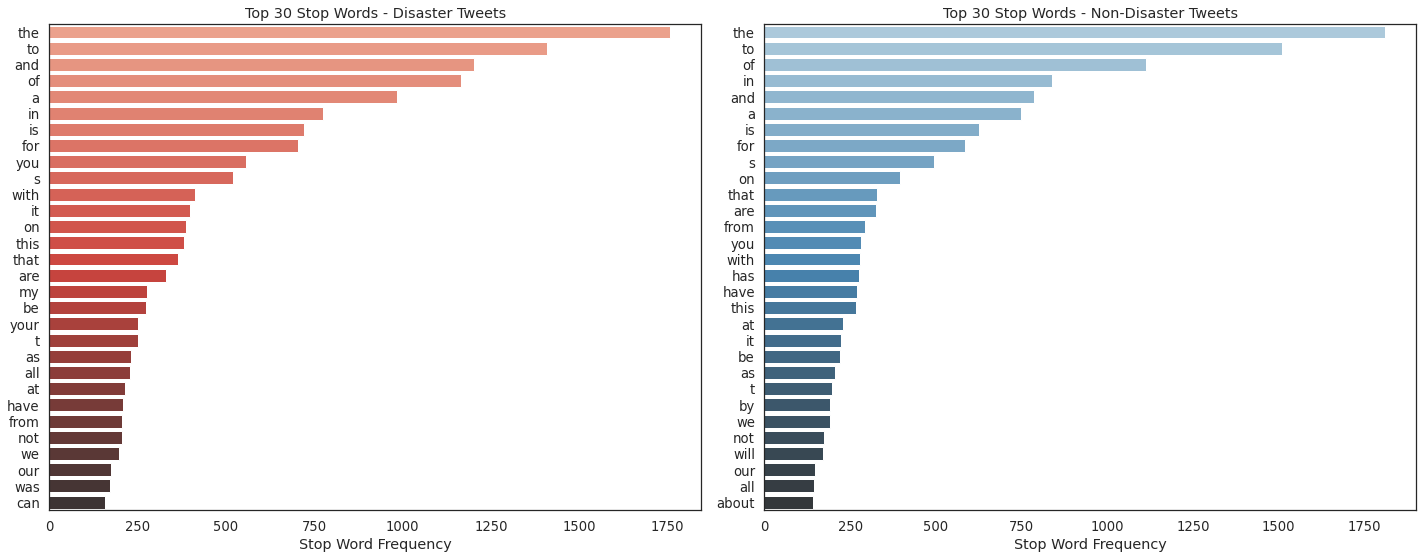

In [17]:
corpus_disaster_dict = create_corpus_dict(0)
corpus_non_disaster_dict = create_corpus_dict(1)

disaster_x, disaster_y = zip(*corpus_disaster_dict)
non_disaster_x, non_disaster_y = zip(*corpus_non_disaster_dict)

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=list(disaster_x)[0:30], x=list(disaster_y)[0:30], orient='h', palette="Reds_d", ax=ax[0])
sns.barplot(y=list(non_disaster_x)[0:30], x=list(non_disaster_y)[0:30], orient='h', palette="Blues_d", ax=ax[1]) 
ax[0].set_title("Top 30 Stop Words - Disaster Tweets")
ax[0].set_xlabel("Stop Word Frequency")
ax[1].set_title("Top 30 Stop Words - Non-Disaster Tweets")
ax[1].set_xlabel("Stop Word Frequency")
plt.tight_layout()
plt.show()

## Common non-stopwords

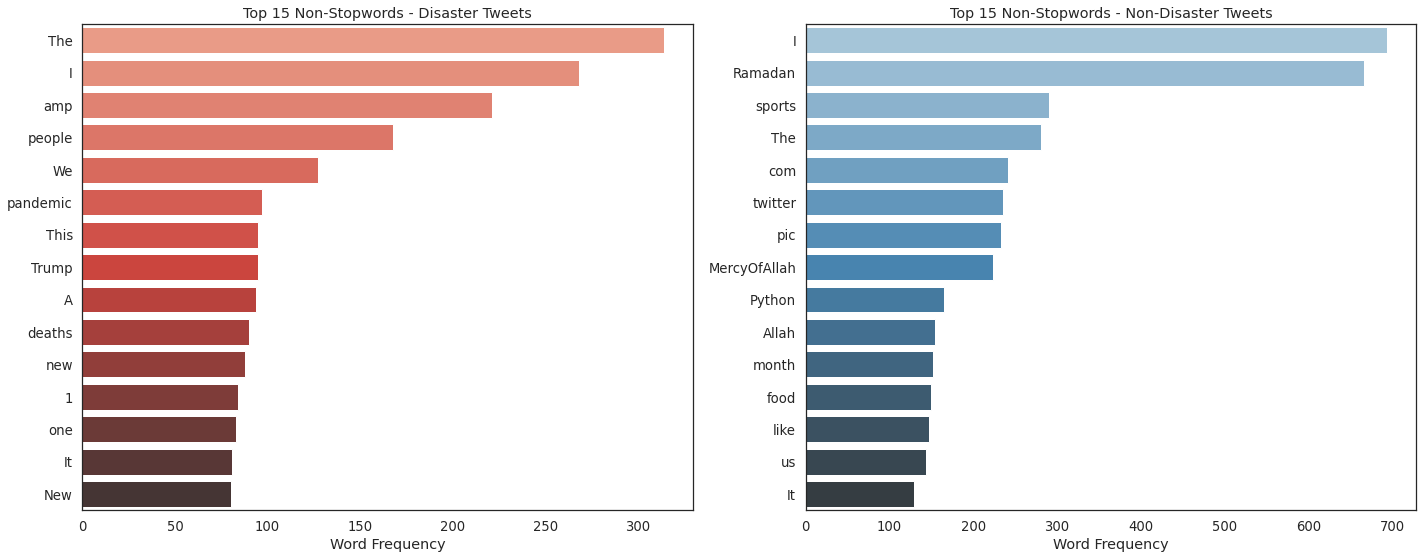

In [18]:
corpus_disaster, corpus_non_disaster = create_corpus(1), create_corpus(0)
counter_disaster, counter_non_disaster = Counter(corpus_disaster), Counter(corpus_non_disaster)
x_disaster, y_disaster, x_non_disaster, y_non_disaster = [], [], [], []

counter = 0
for word, count in counter_disaster.most_common()[0:100]:
    if (word not in stopwords and counter < 15):
        counter += 1
        x_disaster.append(word)
        y_disaster.append(count)

counter = 0
for word, count in counter_non_disaster.most_common()[0:100]:
    if (word not in stopwords and counter < 15):
        counter += 1
        x_non_disaster.append(word)
        y_non_disaster.append(count)

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(x=y_disaster, y=x_disaster, orient='h', palette="Reds_d", ax=ax[0])
sns.barplot(x=y_non_disaster, y=x_non_disaster, orient='h', palette="Blues_d", ax=ax[1])
ax[0].set_title("Top 15 Non-Stopwords - Disaster Tweets")
ax[0].set_xlabel("Word Frequency")
ax[1].set_title("Top 15 Non-Stopwords - Non-Disaster Tweets")
ax[1].set_xlabel("Word Frequency")
plt.tight_layout()
plt.show()

## Common Bigrams

In [19]:
def bigrams(target):
    corpus = train[train["target"] == target]["text"]
    count_vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = count_vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

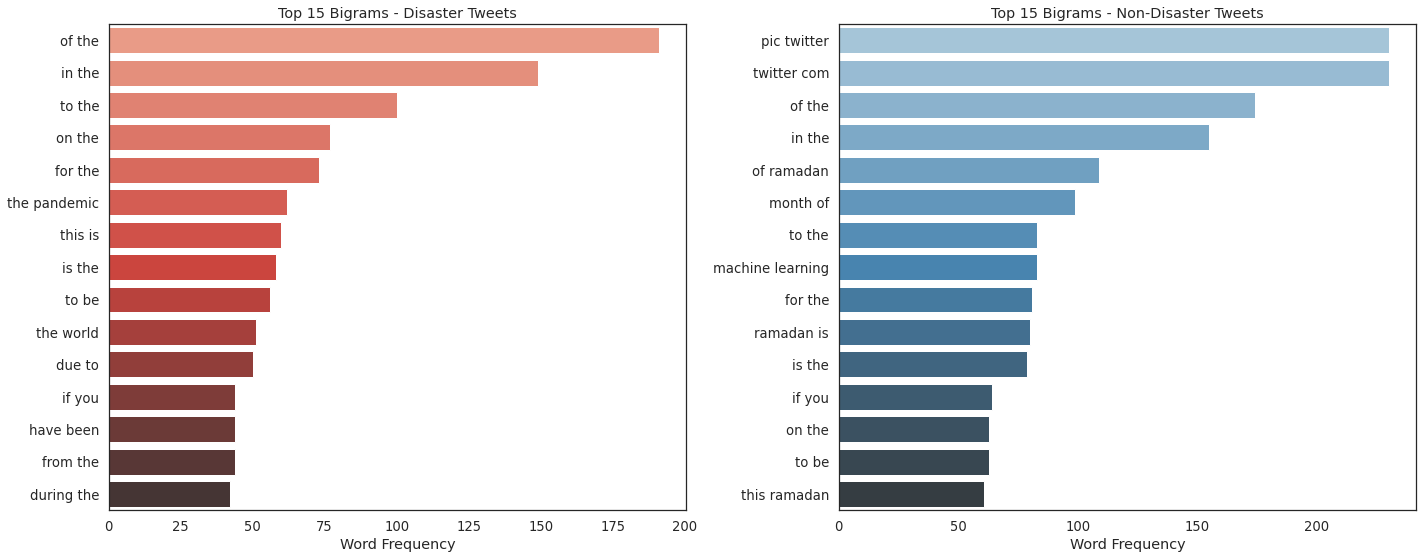

In [20]:
bigrams_disaster = bigrams(1)[:15]
bigrams_non_disaster = bigrams(0)[:15]

x_disaster, y_disaster = map(list, zip(*bigrams_disaster))
x_non_disaster, y_non_disaster = map(list, zip(*bigrams_non_disaster))

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(x=y_disaster, y=x_disaster, orient='h', palette="Reds_d", ax=ax[0])
sns.barplot(x=y_non_disaster, y=x_non_disaster, orient='h', palette="Blues_d", ax=ax[1])

ax[0].set_title("Top 15 Bigrams - Disaster Tweets")
ax[0].set_xlabel("Word Frequency")
ax[1].set_title("Top 15 Bigrams - Non-Disaster Tweets")
ax[1].set_xlabel("Word Frequency")
plt.tight_layout()
plt.show()

### Target

Not Disaster: 51.94%, Disaster: 48.06%


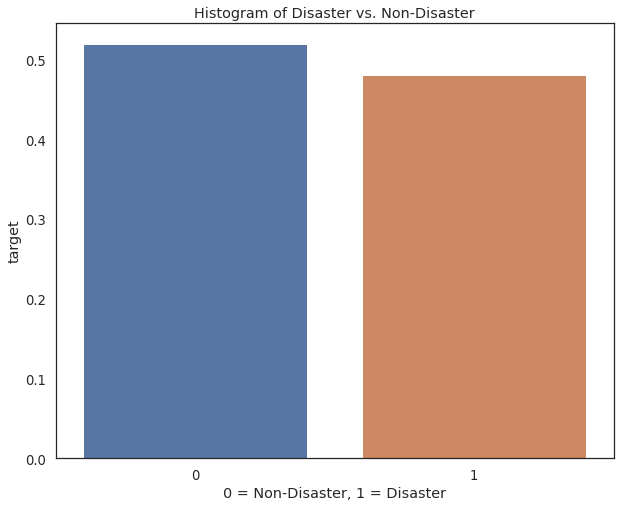

In [21]:
target_vc = train["target"].value_counts(normalize=True)
print("Not Disaster: {:.2%}, Disaster: {:.2%}".format(target_vc[0], target_vc[1]))
sns.barplot(x=target_vc.index, y=target_vc)
plt.title("Histogram of Disaster vs. Non-Disaster")
plt.xlabel("0 = Non-Disaster, 1 = Disaster")
plt.show()

In [22]:
train

,ID,text,target,tweet_length,num_words,avg_word_length
0,train_0,The bitcoin halving is cancelled due to,1,39,7,4.714286
1,train_1,MercyOfAllah In good times wrapped in its gran...,0,117,20,4.900000
2,train_2,266 Days No Digital India No Murder of e learn...,1,93,20,3.700000
3,train_3,India is likely to run out of the remaining RN...,1,112,23,3.913043
4,train_4,In these tough times the best way to grow is t...,0,121,26,3.692308
...,...,...,...,...,...,...
5282,train_6856,The spread of the novel among asylum seekers o...,1,111,21,4.333333
5283,train_6857,Hundreds of Jewish patients are being treated...,1,199,30,5.633333
5284,train_6858,Beats me Honestly most of the people I follow ...,0,167,33,4.090909
5285,train_6859,Help us reach more people by donating and shar...,0,143,25,4.760000


In [23]:
from nltk.corpus import stopwords

#function for removing pattern
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

# remove '#' handle
train['tweet'] = np.vectorize(remove_pattern)(train['text'], "#[\w]*")
test['tweet'] = np.vectorize(remove_pattern)(test['text'], "#[\w]*") 
train.head()

#Delete everything except alphabet
train['tweet'] = train['tweet'].str.replace("[^a-zA-Z#]", " ")
test['tweet'] = test['tweet'].str.replace("[^a-zA-Z#]", " ")
train.head()


#Dropping words whose length is less than 3
train['tweet'] = train['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
test['tweet'] = test['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
train.head()


#convert all the words into lower case
train['tweet'] = train['tweet'].str.lower()
test['tweet'] = test['tweet'].str.lower()


set(stopwords.words('english'))

# set of stop words
stops = set(stopwords.words('english')) 

# tokens of words  
train['tokenized_sents'] = train.apply(lambda row: nltk.word_tokenize(row['tweet']), axis=1)
test['tokenized_sents'] = test.apply(lambda row: nltk.word_tokenize(row['tweet']), axis=1)

#function to remove stop words
def remove_stops(row):
    my_list = row['tokenized_sents']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

#removing stop words
train['clean_tweet'] = train.apply(remove_stops, axis=1)
test['clean_tweet'] = test.apply(remove_stops, axis=1)
train.drop(["tweet","tokenized_sents"], axis = 1, inplace = True)
test.drop(["tweet","tokenized_sents"], axis = 1, inplace = True)

#re-join the words after tokenization
def rejoin_words(row):
    my_list = row['clean_tweet']
    joined_words = ( " ".join(my_list))
    return joined_words

train['clean_tweet'] = train.apply(rejoin_words, axis=1)
test['clean_tweet'] = test.apply(rejoin_words, axis=1)
train.head()


,ID,text,target,tweet_length,num_words,avg_word_length,clean_tweet
0,train_0,The bitcoin halving is cancelled due to,1,39,7,4.714286,bitcoin halving cancelled
1,train_1,MercyOfAllah In good times wrapped in its gran...,0,117,20,4.900000,mercyofallah good times wrapped granular detai...
2,train_2,266 Days No Digital India No Murder of e learn...,1,93,20,3.700000,days digital india murder learning online busi...
3,train_3,India is likely to run out of the remaining RN...,1,112,23,3.913043,india likely remaining kits essential testing ...
4,train_4,In these tough times the best way to grow is t...,0,121,26,3.692308,tough times best grow learn case teach help pe...


## Visualization of all the words using word cloud

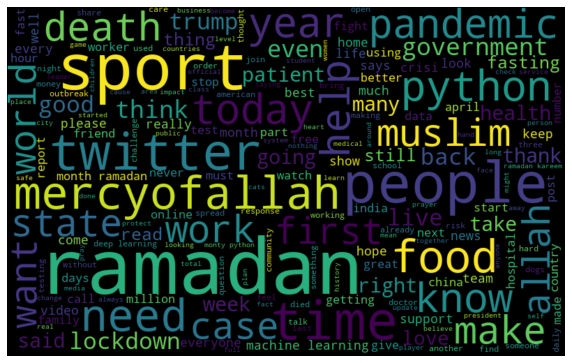

In [24]:
all_word = ' '.join([text for text in train['clean_tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_word) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off') 
plt.show()

## Visualization of all the words which signify real disaster

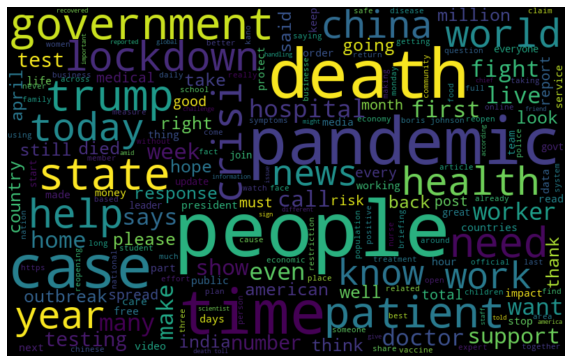

In [25]:
normal_words =' '.join([text for text in train['clean_tweet'][train['target'] == 1]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Visualization of all the words which signify unreal disaster

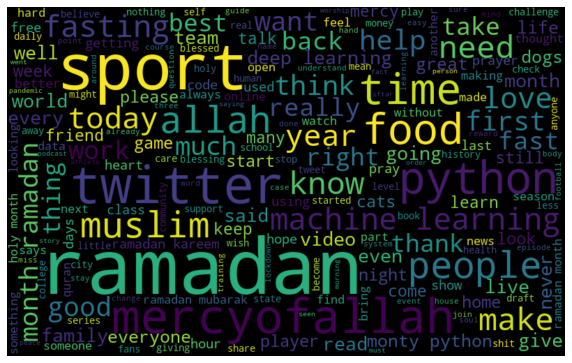

In [26]:
normal_words =' '.join([text for text in train['clean_tweet'][train['target'] == 0]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [27]:
import gc
import os
import time
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date
from transformers import *
from sklearn.metrics import *
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

import os
import gc
import re
import string
import folium
from colorama import Fore, Back, Style, init

import math
import numpy as np
import scipy as sp
import pandas as pd

import random
import networkx as nx
from pandas import Timestamp

from PIL import Image
from IPython.display import SVG
from keras.utils import model_to_dot

import requests
from IPython.display import HTML

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.pyplot as plt

tqdm.pandas()

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import transformers
import tensorflow as tf

from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from tensorflow.keras.models import Model
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.optimizers import Adam
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import LSTM, GRU, Conv1D, SpatialDropout1D

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.constraints import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *


from sklearn import metrics
from sklearn.utils import shuffle
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer  

import nltk
from textblob import TextBlob


from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize

from xgboost import XGBClassifier

stopword=set(STOPWORDS)


lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

np.random.seed(0)
random_state = 29

In [28]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            del obj
    gc.collect()
    
    print("GPU Usage after emptying the cache")
    gpu_usage()

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7410 sha256=2149a8120ec786936f0198db0f98e0dc59da9a34a3aa6f27f540927540d4aeab
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


In [29]:
train = pd.read_csv("../input/covid19-tweet-classification-by-zindiweekendz/updated_train.csv")
test = pd.read_csv("../input/covid19-tweet-classification-by-zindiweekendz/updated_test.csv")
sub= pd.read_csv("../input/covid19-tweet-classification-by-zindiweekendz/updated_ss.csv")

In [30]:
train.describe()


,target
count,5287.000000
mean,0.480613
std,0.499671
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [31]:
test.describe()

,ID,text
count,1962,1962
unique,1962,1962
top,test_2377,The Basics of Data Visualisation with Python via
freq,1,1


In [32]:
train.head()


,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0


In [33]:
test.head()


,ID,text
0,test_2,Why is explained in the video take a look
1,test_3,Ed Davey fasting for Ramadan No contest
2,test_4,Is Doja Cat good or do you just miss Nicki Minaj
3,test_8,How Boris Johnson s cheery wounded in action p...
4,test_9,Man it s terrible Not even a reason to get on ...


In [34]:

sub.head()


,ID,target
0,test_2,0
1,test_3,0
2,test_4,0
3,test_8,0
4,test_9,0


# Preprocessing

In [35]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [36]:
# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Remove all emojis, replace by EMOJI
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

# Factorize elongated words, add ELONG
def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)

# Factorize repeated punctuation, add REPEAT
def remove_repeat_punct(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)


# Remove all punctuations
def remove_all_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

# Remove punctuations
def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" 
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')   
    return text

# Remove all english stopwords
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    return text

In [37]:
def clean_tweet(text):
    
    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    
    # Lower text, replace abbreviations
    text = text.lower()
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)
    
    # Remove emojis / smileys
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    
    # Remove repeated puntuations / words
    text = remove_elongated_words(text)
    text = remove_repeat_punct(text)

    #text = remove_all_punct(text)
    #text = remove_punct(text)
    #text = remove_stopwords(text)

    return text

In [38]:
# Clean text and add a new feature
train["clean_text"] = train["text"].apply(clean_tweet)
test["clean_text"] = test["text"].apply(clean_tweet)

train["clean_tokens"] = train["clean_text"].apply(lambda x: word_tokenize(x))
test["clean_tokens"] = test["clean_text"].apply(lambda x: word_tokenize(x))

In [39]:
train[['clean_text','text']].head(10)

,clean_text,text
0,the bitcoin halving is cancelled due to,The bitcoin halving is cancelled due to
1,mercyofallah in good times wrapped in its gran...,MercyOfAllah In good times wrapped in its gran...
2,NUMBER days no digital india no murder of e le...,266 Days No Digital India No Murder of e learn...
3,india is likely to run out of the remaining rn...,India is likely to run out of the remaining RN...
4,in these tough times the best way to grow is t...,In these tough times the best way to grow is t...
5,fifa has proposed allowing teams to make up to...,FIFA has proposed allowing teams to make up to...
6,lovers of sports especially do you know why so...,Lovers of sports especially do you know why so...
7,ig he kinda cute sometimes shake my head,ig he kinda cute sometimes smh
8,frontline health workers are critical in the f...,Frontline health workers are critical in the f...
9,contact centers are getting overwhelmed with c...,Contact centers are getting overwhelmed with c...


# Vectorisation

In [40]:
from gensim.models import Word2Vec

skip_gram_model = Word2Vec(train['clean_tokens'],size=150,window=3,min_count=2,sg=1)
skip_gram_model.train(train['clean_tokens'],total_examples=len(train['clean_tokens']),epochs=10)

cbow_model = Word2Vec(train['clean_tokens'],size=150,window=3,min_count=2)
cbow_model.train(train['clean_tokens'],total_examples=len(train['clean_tokens']),epochs=10)


train["clean_tokens"] = train["text"].apply(lambda x: word_tokenize(x))
test["clean_tokens"] = test["text"].apply(lambda x: word_tokenize(x))
def get_word_embeddings(token_list,vector,k=150):
    if len(token_list) < 1:
        return np.zeros(k)
    else:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in token_list] 
        
    sum = np.sum(vectorized,axis=0)
    return sum/len(vectorized) 

In [41]:
max_features=5000

# CountVectorizer
count_vectorizer = CountVectorizer(max_features=max_features)
sparce_matrix_train=count_vectorizer.fit_transform(train['clean_text'])
sparce_matrix_test=count_vectorizer.fit_transform(train['clean_text'])

def count_vector(data):
    count_vectorizer = CountVectorizer()
    vect = count_vectorizer.fit_transform(data)
    return vect, count_vectorizer

def tfidf_vector(data):
    tfidf_vectorizer = TfidfVectorizer()
    vect = tfidf_vectorizer.fit_transform(data)
    return vect, tfidf_vectorizer

def skip_gram_vectorizer(tokens,vector):
        embeddings = tokens.apply(lambda x: get_word_embeddings(x, skip_gram_model))
        return list(embeddings)

def cbow_vectorizer(tokens,vector):
        embeddings = tokens.apply(lambda x: get_word_embeddings(x, cbow_model))
        return list(embeddings)

X_train_count, count_vectorizer = count_vector(train['clean_text'])
X_train_tfidf, tfidf_vectorizer = tfidf_vector(train['clean_text'])
X_train_skip_gram = skip_gram_vectorizer(train['clean_tokens'],skip_gram_model)
X_train_cbow = cbow_vectorizer(train['clean_tokens'],cbow_model)

X_test_count = count_vectorizer.transform(test['clean_text'])                                                     
X_test_tfidf = tfidf_vectorizer.transform(test['clean_text'])
X_test_skip_gram = skip_gram_vectorizer(test['clean_tokens'],skip_gram_model)
X_test_cbow = cbow_vectorizer(test['clean_tokens'],cbow_model)

X_train_skip_gram = np.array(X_train_skip_gram)
X_train_cbow = np.array(X_train_cbow)
X_test_skip_gram = np.array(X_test_skip_gram)
X_test_cbow = np.array(X_test_cbow)


import pickle    

with open('count_vectorizer.pickle', 'wb') as handle:
    pickle.dump(count_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('tfidf_vectorizer.pickle', 'wb') as handle:
    pickle.dump(tfidf_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('skip_gram_model.pickle', 'wb') as handle:
    pickle.dump(skip_gram_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('cbow_model.pickle', 'wb') as handle:
    pickle.dump(cbow_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('cbow_model.pickle', 'wb') as handle:
    pickle.dump(cbow_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('cbow_model.pickle', 'wb') as handle:
    pickle.dump(cbow_model, handle, protocol=pickle.HIGHEST_PROTOCOL)




# Models

In [42]:
metrics = pd.DataFrame(columns=['model' ,'vectoriser', 'f1 score', 'train accuracy','test accuracy'])

* LogisticRegression
* SVC
* MultinomialNB
* DecisionTreeClassifier 
* KNeighborsClassifier
* RandomForestClassifier

In [43]:
from joblib import dump

def fit_and_predict(model,x_train,x_test,y_train,y_test,vectoriser):
    classifier = model
    classifier_name = str(classifier.__class__.__name__)

    if classifier_name=="MultinomialNB" and (vectoriser=="skip gram vector" or vectoriser=="cbow vector"):
        return

    classifier.fit(x_train,y_train)
    filename = classifier_name +" using "+ str(vectoriser)+".joblib"
    filename = filename.lower().replace(" ","_")
    dump(model, filename=filename)
    y_pred = classifier.predict(x_test)
    cmatrix = confusion_matrix(y_test,y_pred)


    f,ax = plt.subplots(figsize=(3,3))
    sns.heatmap(cmatrix,annot=True,linewidths=0.5,cbar=False,linecolor="red",fmt='.0f',ax=ax)
    plt.xlabel("y_predict")
    plt.ylabel("y_true")
    ax.set(title=str(classifier))
    plt.show()


    f1score = f1_score(y_test,y_pred,average='weighted')
    train_accuracy = round(classifier.score(x_train,y_train)*100)
    test_accuracy =  round(accuracy_score(y_test,y_pred)*100)

    global metrics
    metrics = metrics.append({
                              'model': classifier_name,
                              'f1 score': f1score, 
                              'train accuracy': train_accuracy, 
                              'test accuracy': test_accuracy, 
                              'vectoriser': str(vectoriser),
                             },
                               ignore_index=True
                            )

    print(str(classifier.__class__.__name__) +" using "+ str(vectoriser))
    print(classification_report(y_test,y_pred))    
    print('Accuracy of classifier on training set:{}%'.format(train_accuracy))
    print('Accuracy of classifier on test set:{}%' .format(test_accuracy))


In [44]:
models=[
        XGBClassifier(max_depth=6, n_estimators=1000),
        LogisticRegression(random_state=random_state),
        SVC(random_state=random_state),
        MultinomialNB(),
        DecisionTreeClassifier(random_state = random_state),
        KNeighborsClassifier(),
        RandomForestClassifier(random_state=random_state),
       ]

[12:25:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


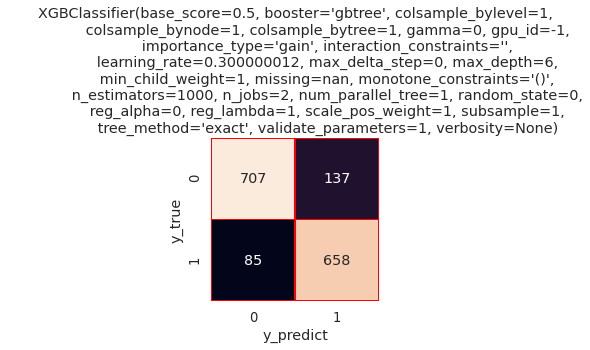

XGBClassifier using Count vector
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       844
           1       0.83      0.89      0.86       743

    accuracy                           0.86      1587
   macro avg       0.86      0.86      0.86      1587
weighted avg       0.86      0.86      0.86      1587

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:86%
[12:25:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


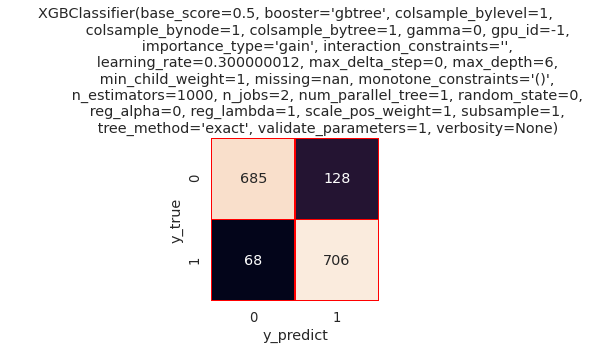

XGBClassifier using Tfidf vector
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       813
           1       0.85      0.91      0.88       774

    accuracy                           0.88      1587
   macro avg       0.88      0.88      0.88      1587
weighted avg       0.88      0.88      0.88      1587

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:88%
[12:26:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


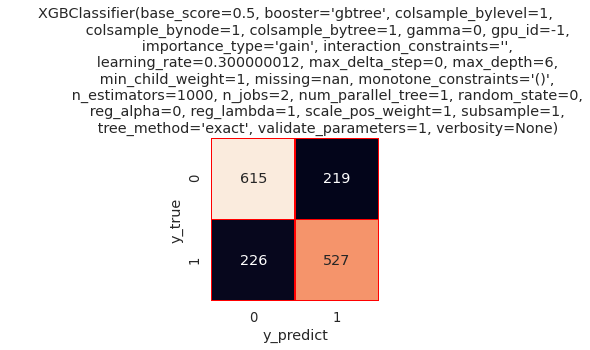

XGBClassifier using skip gram vector
              precision    recall  f1-score   support

           0       0.73      0.74      0.73       834
           1       0.71      0.70      0.70       753

    accuracy                           0.72      1587
   macro avg       0.72      0.72      0.72      1587
weighted avg       0.72      0.72      0.72      1587

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:72%
[12:27:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


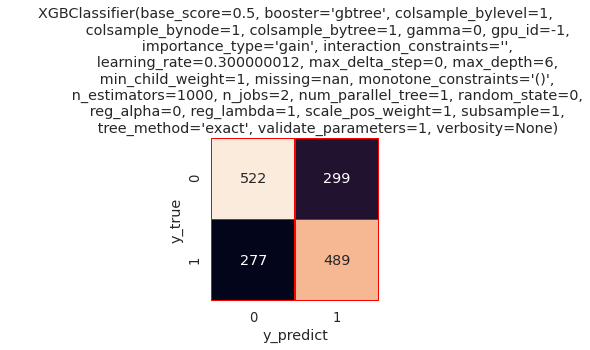

XGBClassifier using cbow vector
              precision    recall  f1-score   support

           0       0.65      0.64      0.64       821
           1       0.62      0.64      0.63       766

    accuracy                           0.64      1587
   macro avg       0.64      0.64      0.64      1587
weighted avg       0.64      0.64      0.64      1587

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:64%


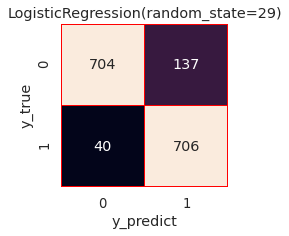

LogisticRegression using Count vector
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       841
           1       0.84      0.95      0.89       746

    accuracy                           0.89      1587
   macro avg       0.89      0.89      0.89      1587
weighted avg       0.90      0.89      0.89      1587

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:89%


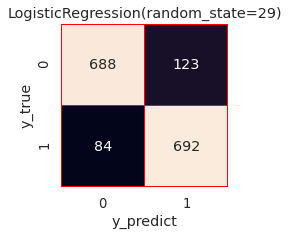

LogisticRegression using Tfidf vector
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       811
           1       0.85      0.89      0.87       776

    accuracy                           0.87      1587
   macro avg       0.87      0.87      0.87      1587
weighted avg       0.87      0.87      0.87      1587

Accuracy of classifier on training set:96%
Accuracy of classifier on test set:87%


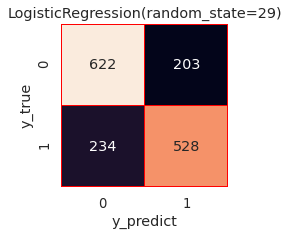

LogisticRegression using skip gram vector
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       825
           1       0.72      0.69      0.71       762

    accuracy                           0.72      1587
   macro avg       0.72      0.72      0.72      1587
weighted avg       0.72      0.72      0.72      1587

Accuracy of classifier on training set:75%
Accuracy of classifier on test set:72%


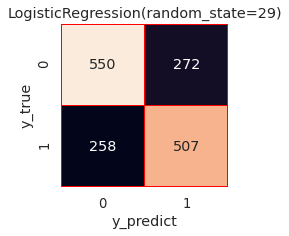

LogisticRegression using cbow vector
              precision    recall  f1-score   support

           0       0.68      0.67      0.67       822
           1       0.65      0.66      0.66       765

    accuracy                           0.67      1587
   macro avg       0.67      0.67      0.67      1587
weighted avg       0.67      0.67      0.67      1587

Accuracy of classifier on training set:69%
Accuracy of classifier on test set:67%


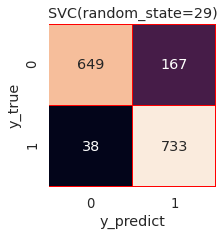

SVC using Count vector
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       816
           1       0.81      0.95      0.88       771

    accuracy                           0.87      1587
   macro avg       0.88      0.87      0.87      1587
weighted avg       0.88      0.87      0.87      1587

Accuracy of classifier on training set:97%
Accuracy of classifier on test set:87%


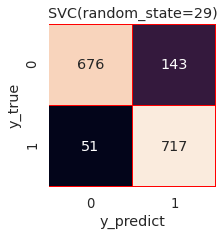

SVC using Tfidf vector
              precision    recall  f1-score   support

           0       0.93      0.83      0.87       819
           1       0.83      0.93      0.88       768

    accuracy                           0.88      1587
   macro avg       0.88      0.88      0.88      1587
weighted avg       0.88      0.88      0.88      1587

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:88%


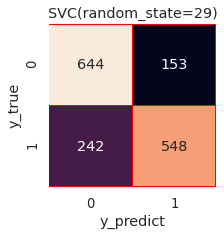

SVC using skip gram vector
              precision    recall  f1-score   support

           0       0.73      0.81      0.77       797
           1       0.78      0.69      0.74       790

    accuracy                           0.75      1587
   macro avg       0.75      0.75      0.75      1587
weighted avg       0.75      0.75      0.75      1587

Accuracy of classifier on training set:79%
Accuracy of classifier on test set:75%


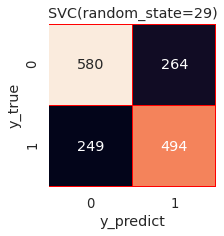

SVC using cbow vector
              precision    recall  f1-score   support

           0       0.70      0.69      0.69       844
           1       0.65      0.66      0.66       743

    accuracy                           0.68      1587
   macro avg       0.68      0.68      0.68      1587
weighted avg       0.68      0.68      0.68      1587

Accuracy of classifier on training set:72%
Accuracy of classifier on test set:68%


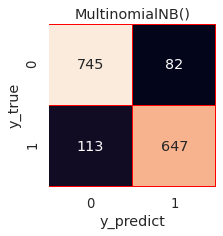

MultinomialNB using Count vector
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       827
           1       0.89      0.85      0.87       760

    accuracy                           0.88      1587
   macro avg       0.88      0.88      0.88      1587
weighted avg       0.88      0.88      0.88      1587

Accuracy of classifier on training set:97%
Accuracy of classifier on test set:88%


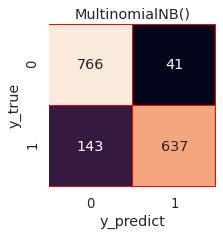

MultinomialNB using Tfidf vector
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       807
           1       0.94      0.82      0.87       780

    accuracy                           0.88      1587
   macro avg       0.89      0.88      0.88      1587
weighted avg       0.89      0.88      0.88      1587

Accuracy of classifier on training set:96%
Accuracy of classifier on test set:88%


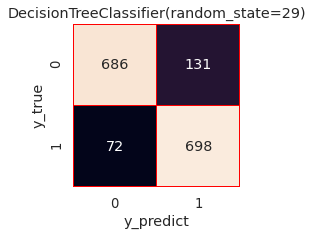

DecisionTreeClassifier using Count vector
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       817
           1       0.84      0.91      0.87       770

    accuracy                           0.87      1587
   macro avg       0.87      0.87      0.87      1587
weighted avg       0.87      0.87      0.87      1587

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:87%


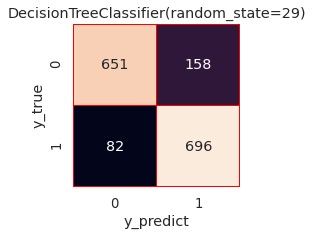

DecisionTreeClassifier using Tfidf vector
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       809
           1       0.81      0.89      0.85       778

    accuracy                           0.85      1587
   macro avg       0.85      0.85      0.85      1587
weighted avg       0.85      0.85      0.85      1587

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:85%


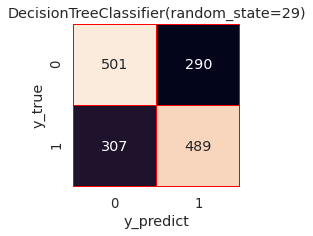

DecisionTreeClassifier using skip gram vector
              precision    recall  f1-score   support

           0       0.62      0.63      0.63       791
           1       0.63      0.61      0.62       796

    accuracy                           0.62      1587
   macro avg       0.62      0.62      0.62      1587
weighted avg       0.62      0.62      0.62      1587

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:62%


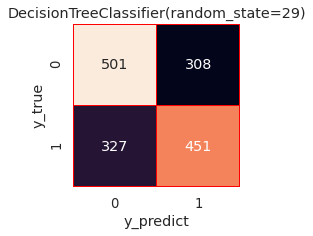

DecisionTreeClassifier using cbow vector
              precision    recall  f1-score   support

           0       0.61      0.62      0.61       809
           1       0.59      0.58      0.59       778

    accuracy                           0.60      1587
   macro avg       0.60      0.60      0.60      1587
weighted avg       0.60      0.60      0.60      1587

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:60%


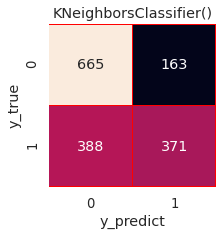

KNeighborsClassifier using Count vector
              precision    recall  f1-score   support

           0       0.63      0.80      0.71       828
           1       0.69      0.49      0.57       759

    accuracy                           0.65      1587
   macro avg       0.66      0.65      0.64      1587
weighted avg       0.66      0.65      0.64      1587

Accuracy of classifier on training set:79%
Accuracy of classifier on test set:65%


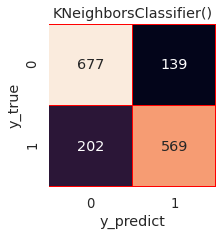

KNeighborsClassifier using Tfidf vector
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       816
           1       0.80      0.74      0.77       771

    accuracy                           0.79      1587
   macro avg       0.79      0.78      0.78      1587
weighted avg       0.79      0.79      0.78      1587

Accuracy of classifier on training set:87%
Accuracy of classifier on test set:79%


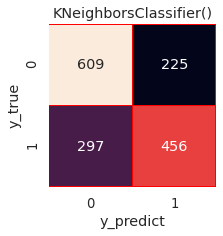

KNeighborsClassifier using skip gram vector
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       834
           1       0.67      0.61      0.64       753

    accuracy                           0.67      1587
   macro avg       0.67      0.67      0.67      1587
weighted avg       0.67      0.67      0.67      1587

Accuracy of classifier on training set:79%
Accuracy of classifier on test set:67%


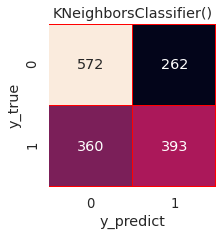

KNeighborsClassifier using cbow vector
              precision    recall  f1-score   support

           0       0.61      0.69      0.65       834
           1       0.60      0.52      0.56       753

    accuracy                           0.61      1587
   macro avg       0.61      0.60      0.60      1587
weighted avg       0.61      0.61      0.61      1587

Accuracy of classifier on training set:75%
Accuracy of classifier on test set:61%


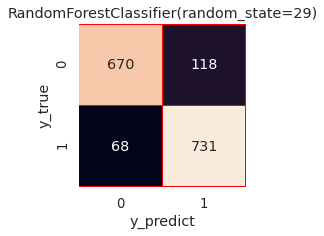

RandomForestClassifier using Count vector
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       788
           1       0.86      0.91      0.89       799

    accuracy                           0.88      1587
   macro avg       0.88      0.88      0.88      1587
weighted avg       0.88      0.88      0.88      1587

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:88%


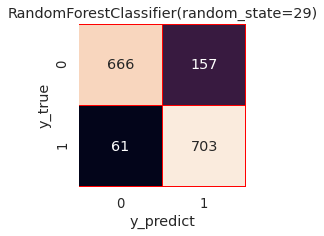

RandomForestClassifier using Tfidf vector
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       823
           1       0.82      0.92      0.87       764

    accuracy                           0.86      1587
   macro avg       0.87      0.86      0.86      1587
weighted avg       0.87      0.86      0.86      1587

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:86%


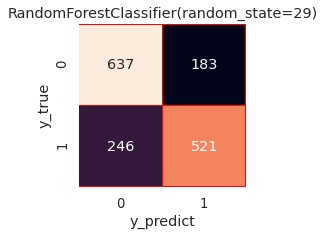

RandomForestClassifier using skip gram vector
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       820
           1       0.74      0.68      0.71       767

    accuracy                           0.73      1587
   macro avg       0.73      0.73      0.73      1587
weighted avg       0.73      0.73      0.73      1587

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:73%


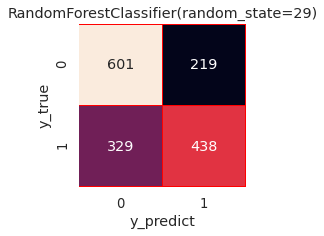

RandomForestClassifier using cbow vector
              precision    recall  f1-score   support

           0       0.65      0.73      0.69       820
           1       0.67      0.57      0.62       767

    accuracy                           0.65      1587
   macro avg       0.66      0.65      0.65      1587
weighted avg       0.66      0.65      0.65      1587

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:65%


In [45]:
for model in models:
    y = train.target

    x = X_train_count
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)
    fit_and_predict(model,x_train,x_test,y_train,y_test,'Count vector')
    
    x = X_train_tfidf
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)
    fit_and_predict(model,x_train,x_test,y_train,y_test, 'Tfidf vector')
    
    x = X_train_skip_gram
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)
    fit_and_predict(model,x_train,x_test,y_train,y_test, 'skip gram vector')
    
    x = X_train_cbow
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)
    fit_and_predict(model,x_train,x_test,y_train,y_test, 'cbow vector')    

In [46]:
metrics = metrics.sort_values('f1 score',ascending=False)

In [47]:
metrics

,model,vectoriser,f1 score,train accuracy,test accuracy
4,LogisticRegression,Count vector,0.888460,100,89
13,MultinomialNB,Tfidf vector,0.883448,96,88
22,RandomForestClassifier,Count vector,0.882656,100,88
9,SVC,Tfidf vector,0.877574,100,88
12,MultinomialNB,Count vector,0.876978,97,88
1,XGBClassifier,Tfidf vector,0.876435,100,88
14,DecisionTreeClassifier,Count vector,0.872050,100,87
8,SVC,Count vector,0.870268,97,87
5,LogisticRegression,Tfidf vector,0.869557,96,87
23,RandomForestClassifier,Tfidf vector,0.862440,100,86


In [48]:
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% |  2% |


### LSTM

In [49]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM,GRU, Dropout, Activation, Input, Flatten, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras import layers
from keras import optimizers
from functools import reduce

In [50]:
def train_lstm(x_train,x_test,y_train,y_test,vectorizer_name,vocab_size,input_length):
    epochs = 1
    verbose = 1
    batch_size = 32
    embed_dim = 32
    optimizer = optimizers.Adam(lr=0.002)
    
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim,input_length = input_length))
    model.add(Dropout(0.2))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics = ['accuracy'])
    
    print(model.summary())

    model.fit(x_train, y_train, epochs = epochs, verbose = verbose, batch_size=batch_size, validation_data=(x_test, y_test))

    model_name = "LSTM using "+ vectorizer_name 
    model.save(model_name)
    y_pred = model.predict(x_test)

    f1score = f1_score(y_test,y_pred.round(),average='weighted')
    train_accuracy = round(accuracy_score(y_train,reduce(list.__add__, model.predict(x_train).round().tolist()))*100)
    test_accuracy =  round(accuracy_score(y_test,y_pred.round())*100)

    global metrics
    metrics = metrics.append({
                              'model': model_name,
                              'f1 score': f1score, 
                              'train accuracy': train_accuracy, 
                              'test accuracy': test_accuracy, 
                              'vectoriser': vectorizer_name,
                             },
                               ignore_index=True
                            )

    print(model_name)
    print(classification_report(y_test,y_pred.round()))    
    print('Accuracy of classifier on training set:{}%'.format(train_accuracy))
    print('Accuracy of classifier on test set:{}%' .format(test_accuracy))

In [51]:
y = train['target'].values


# x_train, x_test, y_train, y_test = train_test_split(X_train_cbow),y, test_size = 0.3)
# train_lstm(x_train,x_test,y_train,y_test, 'cbow vector',5329,150)

x_train, x_test, y_train, y_test = train_test_split(X_train_skip_gram,y, test_size = 0.3)
train_lstm(x_train,x_test,y_train,y_test, 'skip gram vector',5329,150)

# x_train, x_test, y_train, y_test = train_test_split(X_train_count,y, test_size = 0.3)
# train_lstm(x_train,x_test,y_train,y_test,'Count vector',14455,7613)

# x_train, x_test, y_train, y_test = train_test_split(X_train_tfidf,y, test_size = 0.3)
# train_lstm(x_train,x_test,y_train,y_test, 'Tfidf vector',14455,7613)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 32)           170528    
_________________________________________________________________
dropout (Dropout)            (None, 150, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 178,881
Trainable params: 178,881
Non-trainable params: 0
_________________________________________________________________
None
116/116 [==============================] - 74s 615ms/step - loss: 0.6946 - accuracy: 0.4867 - val_loss: 0.6917 - val_accuracy: 0.5299
LSTM using skip gram vector
              precision    recall  f1-score   support

           0       0.53   

In [52]:
%reset -f

In [53]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import gc
def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            del obj
    gc.collect()
    
    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 95% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% |  2% |


## Electra

In [54]:
import re
import torch
from transformers import ElectraTokenizer, ElectraForSequenceClassification,AdamW
import torch
from sklearn.metrics import classification_report
import random
import time
import datetime
import numpy as np
import pandas as pd
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

In [55]:
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

We will use the GPU: Tesla P100-PCIE-16GB


In [56]:
train = pd.read_csv("../input/covid19-tweet-classification-by-zindiweekendz/updated_train.csv")
test = pd.read_csv("../input/covid19-tweet-classification-by-zindiweekendz/updated_test.csv")

df_train= train
df_test= test

In [57]:

def preprocess(text):
    text=text.lower()
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    text = re.sub(r"(?:\@)\w+", '', text)
    text=text.encode("ascii",errors="ignore").decode()
    text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
    text=re.sub(r'[!]+','!',text)
    text=re.sub(r'[?]+','?',text)
    text=re.sub(r'[.]+','.',text)
    text=re.sub(r"'","",text)
    text=re.sub(r"\(","",text)
    text=re.sub(r"\)","",text)
    text=" ".join(text.split())
    return text
df_train['text'] = df_train['text'].apply(preprocess)
df_test['text'] = df_test['text'].apply(preprocess)
df_train=df_train[df_train["text"]!='']

In [58]:
df_train=df_train[["text","target"]]

In [59]:
texts = df_train.text.values
labels = df_train.target.values

In [60]:
torch.cuda.empty_cache()
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator',num_labels=2)
model.cuda()

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [61]:
indices=tokenizer.batch_encode_plus(texts,max_length=64,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]

In [62]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.2)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

In [63]:
# Converting all of our data into torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [64]:
batch_size = 32

# the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [65]:
optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [66]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [67]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [68]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # As we unpack the batch, we'll also copy each tensor to the GPU  
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)

        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
      
print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...
  Batch    50  of    133.    Elapsed: 0:00:11.
  Batch   100  of    133.    Elapsed: 0:00:23.
  Average training loss: 0.60
  Training epoch took: 0:00:30

======== Epoch 2 / 5 ========
Training...
  Batch    50  of    133.    Elapsed: 0:00:11.
  Batch   100  of    133.    Elapsed: 0:00:23.
  Average training loss: 0.36
  Training epoch took: 0:00:30

======== Epoch 3 / 5 ========
Training...
  Batch    50  of    133.    Elapsed: 0:00:11.
  Batch   100  of    133.    Elapsed: 0:00:22.
  Average training loss: 0.28
  Training epoch took: 0:00:30

======== Epoch 4 / 5 ========
Training...
  Batch    50  of    133.    Elapsed: 0:00:11.
  Batch   100  of    133.    Elapsed: 0:00:22.
  Average training loss: 0.23
  Training epoch took: 0:00:30

======== Epoch 5 / 5 ========
Training...
  Batch    50  of    133.    Elapsed: 0:00:11.
  Batch   100  of    133.    Elapsed: 0:00:23.
  Average training loss: 0.22
  Training epoch took: 0:00:30

Training 

In [69]:
# Validation               

print("")
print("Running Validation...")

t0 = time.time()

model.eval()

preds=[]
true=[]

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # Get the "logits" output by the model. The "logits" are the output
    # values prior to applying an activation function like the softmax.
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    preds.append(logits)
    true.append(label_ids)
    # Calculate the accuracy for this batch of test sentences.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches
    nb_eval_steps += 1

# Report the final accuracy for this validation run.
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Validation took: {:}".format(format_time(time.time() - t0)))


Running Validation...
Accuracy: 0.88
Validation took: 0:00:02


In [70]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in preds for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true for item in sublist]

In [71]:
comments1 = df_test.text.values

indices1=tokenizer.batch_encode_plus(comments1,max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_ids1=indices1["input_ids"]
attention_masks1=indices1["attention_mask"]

prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)


# Set the batch size.  
batch_size = 32 

# Create the DataLoader.
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)



In [72]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader1:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids1, b_input_mask1 = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs1 = model(b_input_ids1, token_type_ids=None, 
                      attention_mask=b_input_mask1)

  logits1 = outputs1[0]

  # Move logits and labels to CPU
  logits1 = logits1.detach().cpu().numpy()
  
  
  # Store predictions and true labels
  predictions.append(logits1)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

Predicting labels for 1,962 test sentences...


In [73]:
submission = pd.read_csv("/kaggle/input/covid19-tweet-classification-by-zindiweekendz/updated_ss.csv")
submission.to_csv('submission.csv', index=False)
print(submission)

             ID  target
0        test_2       0
1        test_3       0
2        test_4       0
3        test_8       0
4        test_9       0
...         ...     ...
1957  test_2932       0
1958  test_2934       0
1959  test_2936       0
1960  test_2937       0
1961  test_2940       0

[1962 rows x 2 columns]


In [74]:
df_leak = pd.read_csv('/kaggle/input/disasters-on-social-media/socialmedia-disaster-tweets-DFE.csv', encoding ='ISO-8859-1')[['choose_one', 'text']]

# Creating target and id
df_leak['target'] = (df_leak['choose_one'] == 'Relevant').astype(np.int8)
df_leak['id'] = df_leak.index.astype(np.int16)
df_leak.drop(columns=['choose_one', 'text'], inplace=True)

# Merging target to test set
df_test = df_test.merge(df_leak, on=['id'], how='left')

print('Leaked Data Set Shape = {}'.format(df_leak.shape))
print('Leaked Data Set Memory Usage = {:.2f} MB'.format(df_leak.memory_usage().sum() / 1024**2))
print(df_test)
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = df_test['target'].values
submission.to_csv('submission.csv', index=False)
print(submission)

KeyError: 'id'